#  Apps Dataset
Google Play Store dataset을 가져왔습니다.   
Rating 컬럼을 target으로 설정하고 예측하는 앙상블을 진행해봅시다  

## 앙상블 조건
1. 이상치 처리
2. 범주형 변수 처리 : 비슷한 것 끼리 묶기 , 더미변수화 등  
3. 베이스 모델 하이퍼파라미터 튜닝  
4. stacking : 최소 두 가지 방법 시도   
5. 앙상블에 대한 설명 주석을 마크다운으로 꼼꼼히!  

|  <center>변수명</center> |  <center>설명</center> |  <center>비고</center> |
|:--------|:--------|:--------|
| App | 어플명 | |  
| Rating | 평점 | target |
| Reviews | 리뷰갯수 | |
| Size | 어플 크기 | |
| Installs | 다운로드 횟수 | |
| Price | 가격 | |
| Content Rating | 관람가 | |
| Genres | 세부장르 | |
| Last Updated | 마지막 업데이트 | |

In [399]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [400]:
# 경로 설정
import os 
os.chdir('/content/gdrive/MyDrive/2021/투빅스 정규세션/Week4')

In [401]:
# ready
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization

from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

In [402]:
# Load Data
train = pd.read_csv('ggstore_train.csv',encoding = 'unicode_escape')
test = pd.read_csv('ggstore_test.csv',encoding = 'unicode_escape')

## 1. EDA & Data Processing


* 데이터 확인 및 결측치 확인

In [403]:
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01,2
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2018-06-08,3
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2018-06-20,4


In [404]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5616 non-null   object 
 1   Category        5616 non-null   object 
 2   Rating          5616 non-null   float64
 3   Reviews         5616 non-null   int64  
 4   Size            5616 non-null   float64
 5   Installs        5616 non-null   float64
 6   Type            5616 non-null   int64  
 7   Price           5616 non-null   float64
 8   Content Rating  5616 non-null   object 
 9   Genres          5616 non-null   object 
 10  Last Updated    5616 non-null   object 
 11  Id              5616 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 526.6+ KB


In [405]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1404 non-null   object 
 1   Category        1404 non-null   object 
 2   Reviews         1404 non-null   int64  
 3   Size            1404 non-null   float64
 4   Installs        1404 non-null   float64
 5   Type            1404 non-null   int64  
 6   Price           1404 non-null   float64
 7   Content Rating  1404 non-null   object 
 8   Genres          1404 non-null   object 
 9   Last Updated    1404 non-null   object 
 10  Id              1404 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 120.8+ KB


In [406]:
## 결측치 확인
train.isna().sum() #결측치 없음

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Id                0
dtype: int64

In [407]:
test.isna().sum() #결측치 없음

App               0
Category          0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Id                0
dtype: int64

In [408]:
#예측시 필요 없는 Id column 제거
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [409]:
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2018-06-08
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2018-06-20


In [410]:
test.head()

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
0,Dr.Android Repair Master 2017,PRODUCTIVITY,1205,4.3,100000.0,0,0.00,Everyone,Productivity,2018-06-10
1,DR CONTROL,FAMILY,267,1.5,10000.0,0,0.00,Everyone,Entertainment,2017-03-08
2,Dr Driving Racer,GAME,183,68.0,10000.0,0,0.00,Everyone,Racing,2018-06-14
3,Dr. McDougall Mobile Cookbook,HEALTH_AND_FITNESS,76,1.2,1000.0,1,4.99,Everyone,Health & Fitness,2015-01-26
4,Dr. Seuss's ABC,FAMILY,429,12.0,10000.0,1,3.99,Everyone,Books & Reference;Education,2018-02-26


#### 연속형 변수

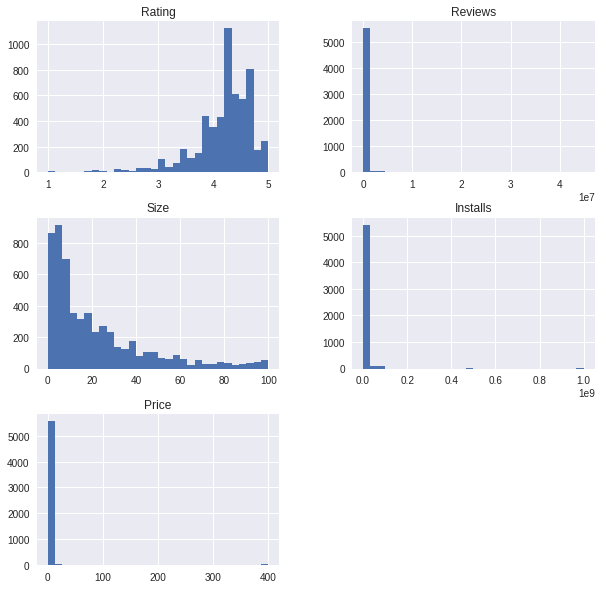

In [411]:
# 연속형 변수 분포 확인
continuous = train[['Rating','Reviews','Size','Installs','Price']]
continuous.hist(bins=30,figsize=(10,10))
plt.show()

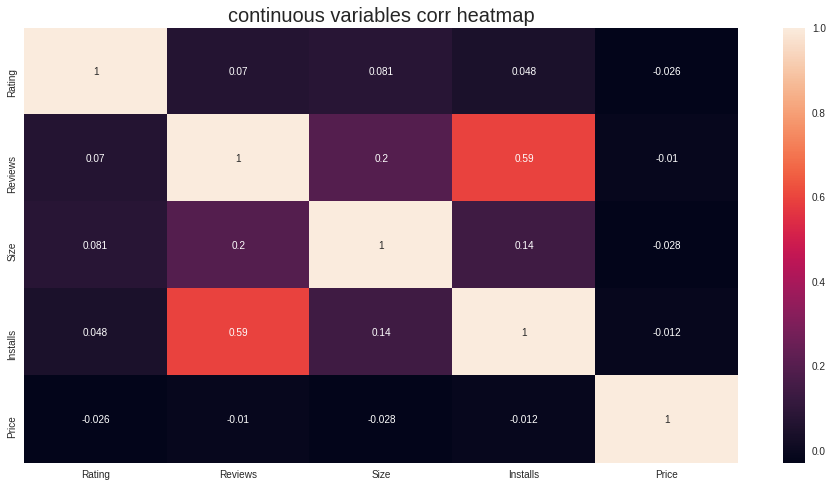

In [412]:
# 연속형 변수 heatmap 상관관계 시각화
plt.figure(figsize=(16,8))
sns.heatmap(continuous.corr(), annot=True)
plt.title('continuous variables corr heatmap', fontsize=20)

plt.show()

상관관계를 살펴볼 때 `Reviews`와 `Installs`의 상관관계가 가장 높다는 것을 확인할 수 있었다. 이것으로 앱의 다운로드 횟수가 많을수록 리뷰를 남길 확률이 높다는 것을 유추할 수 있었다. 

또한, 해당 과제는 각 변수들의 값들을 통해 `Rating` 을 예측하는 것이다. 
`Rating` 변수와는 `Size`와 `Reviews`변수가 상대적으로 높은 상관관계를 보이는 것을 확인할 수 있다.

### 연속형 변수 이상치 확인
Type 은 유무료를 나타내는 범주형

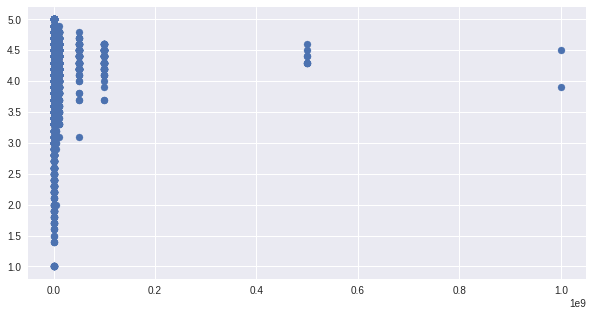

In [413]:
# Installs
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Installs'], y = continuous['Rating'])

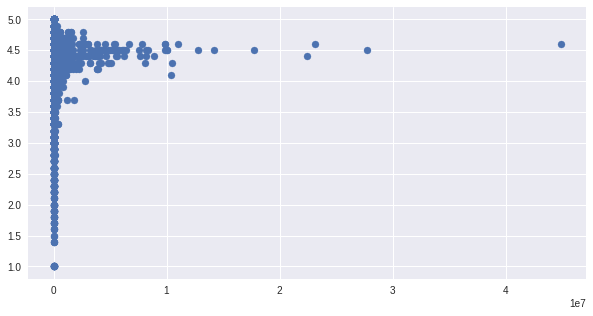

In [414]:
# Reviews
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Reviews'], y = continuous['Rating'])

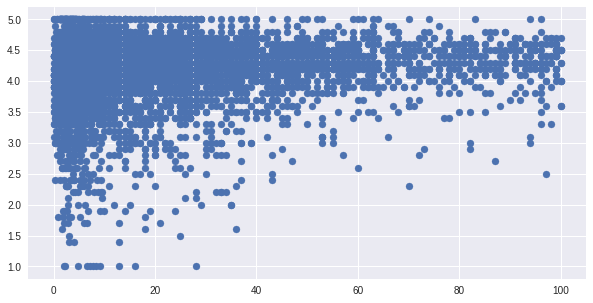

In [415]:
# Size
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Size'], y = continuous['Rating'])

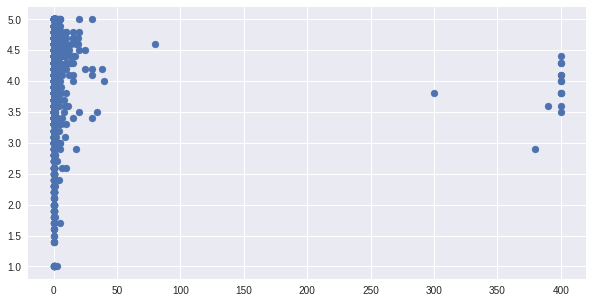

In [416]:
# Price
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Price'], y = continuous['Rating'])

#### IQR 기준으로 완전 이상한거 몇개만 제거 해 봅시다
저는 Installs,Reviews 와 Price에서만 제거해보겠습니당

* IQR 기준으로

In [417]:
def remove_outlier(df,col):
  data = df[col]
  q25 = np.percentile(data.values,25)
  q75 = np.percentile(data.values,75)

  IQR = q75 - q25
  IQR = IQR * 1.5
  low = q25-IQR ; high = q75+IQR
  outlier_index = data[(data<low)|(data>high)].index
  #print(len(outlier_index))
  #df.drop(outlier_index, axis=0, inplace=True)
  #print(df.shape)
  #return df
  return len(outlier_index)

In [418]:
print(remove_outlier(continuous,'Installs'))
print(remove_outlier(continuous,'Reviews'))
print(remove_outlier(continuous,'Price'))

1162
924
441


IQR 기준이면 너무 많은 이상치가 발견되서 데이터 손실이 너무 컸습니다!  
scatter plot 에 당장 눈에 보이는 정말 몇개만 제거합시다  


In [419]:
train.shape # 원래 train shape

(5616, 11)

* 직관적으로

In [421]:
# continuous = continuous.query('Installs < 100000000 and Price < 250 and Reviews < 40000000')
# continuous.shape

In [434]:
## 이상치 제거
train = train[train.Reviews <4e7]
train = train[train.Installs <0.2e9]
train = train[train.Price <200]

In [435]:
train.shape

(5590, 11)

In [436]:
train.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
dtype: int64

In [301]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5590 entries, 0 to 5615
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5590 non-null   object 
 1   Category        5590 non-null   object 
 2   Rating          5590 non-null   float64
 3   Reviews         5590 non-null   int64  
 4   Size            5590 non-null   float64
 5   Installs        5590 non-null   float64
 6   Type            5590 non-null   int64  
 7   Price           5590 non-null   float64
 8   Content Rating  5590 non-null   object 
 9   Genres          5590 non-null   object 
 10  Last Updated    5590 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 524.1+ KB


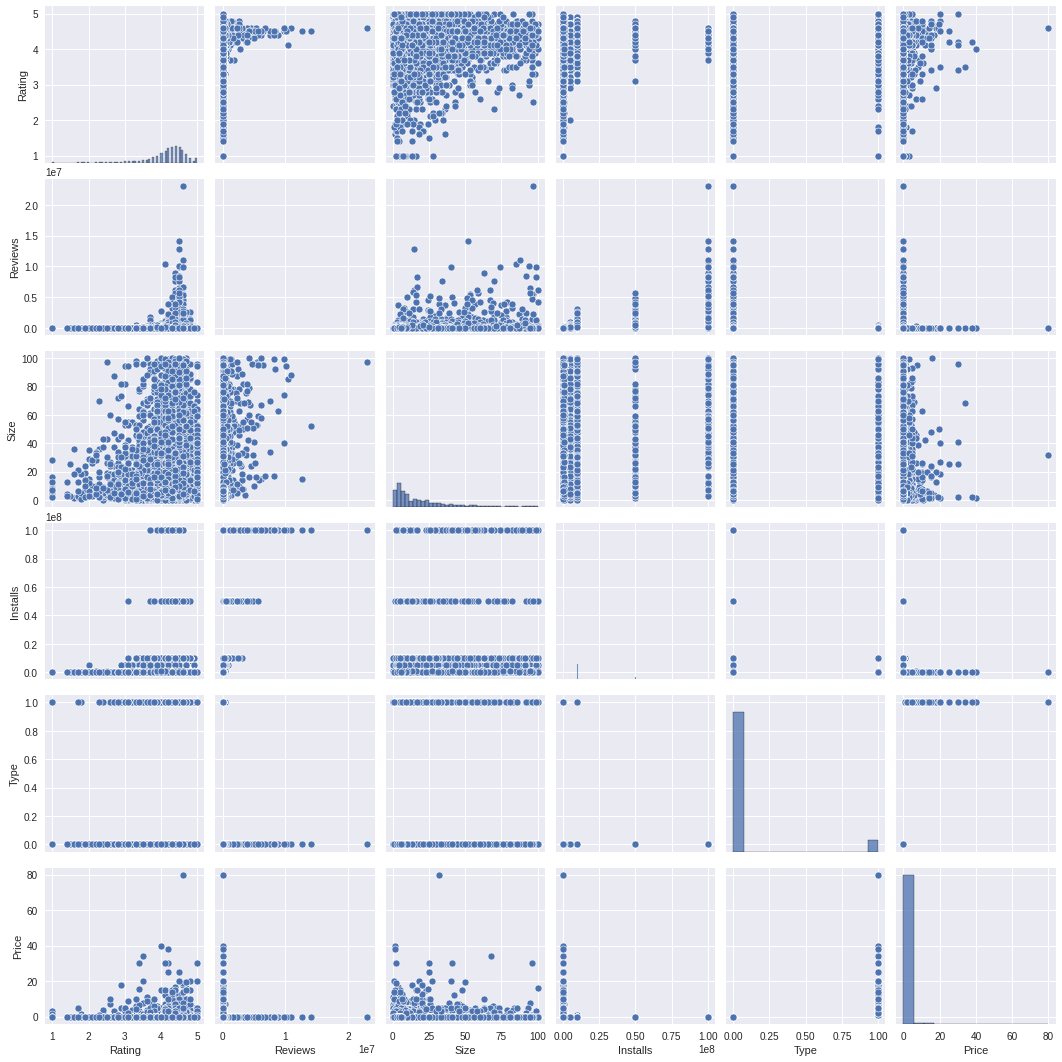

In [302]:
# 이상치 제거 후 변수간 분포 확인 (Rating 중심으로 살펴보기)
sns.pairplot(train)

In [437]:
# 삭제된 행에 대한 index reset 
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### 범주형 변수 확인  
Category, Content Rating, Genres 확인

In [438]:
category_count = train['Category'].value_counts()
category_count

FAMILY                 1098
GAME                    652
TOOLS                   462
MEDICAL                 253
PERSONALIZATION         227
LIFESTYLE               215
FINANCE                 195
PHOTOGRAPHY             175
PRODUCTIVITY            172
HEALTH_AND_FITNESS      171
BUSINESS                166
COMMUNICATION           151
SPORTS                  143
SHOPPING                139
SOCIAL                  122
DATING                  121
NEWS_AND_MAGAZINES      113
BOOKS_AND_REFERENCE     109
TRAVEL_AND_LOCAL        108
VIDEO_PLAYERS            90
EDUCATION                88
MAPS_AND_NAVIGATION      76
FOOD_AND_DRINK           69
ENTERTAINMENT            64
ART_AND_DESIGN           57
LIBRARIES_AND_DEMO       57
AUTO_AND_VEHICLES        55
HOUSE_AND_HOME           48
COMICS                   46
PARENTING                43
WEATHER                  37
EVENTS                   34
BEAUTY                   34
Name: Category, dtype: int64

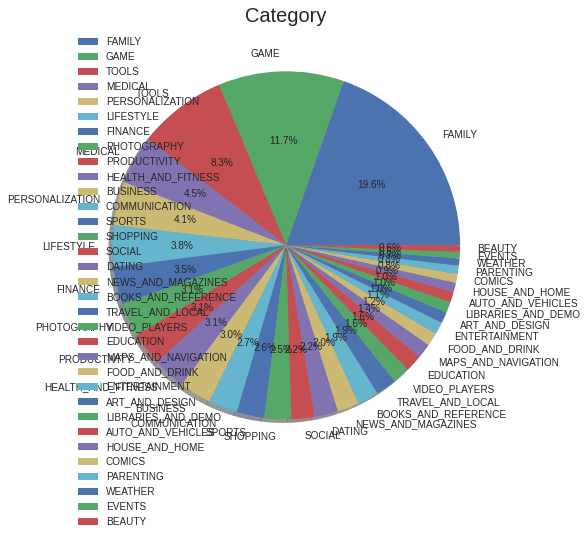

In [439]:
# Category 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(category_count,labels=category_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Category',size = 20)
plt.legend()
plt.show()

In [440]:
con_rating_count = train['Content Rating'].value_counts()
con_rating_count

Everyone           4510
Teen                586
Mature 17+          281
Everyone 10+        210
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

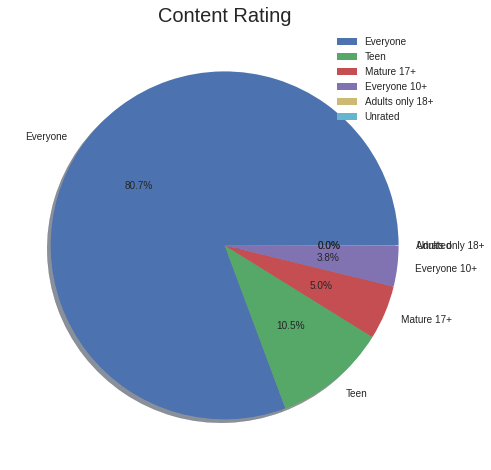

In [441]:
# Content Rating 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(con_rating_count,labels=con_rating_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Content Rating',size = 20)
plt.legend()
plt.show()

In [442]:
genres_count = train['Genres'].value_counts()
genres_count

Tools                                    462
Entertainment                            333
Education                                309
Medical                                  253
Personalization                          227
Lifestyle                                214
Action                                   213
Finance                                  195
Photography                              175
Productivity                             172
Health & Fitness                         171
Business                                 166
Communication                            151
Sports                                   149
Shopping                                 139
Arcade                                   128
Social                                   122
Dating                                   121
News & Magazines                         113
Simulation                               110
Books & Reference                        109
Travel & Local                           107
Video Play

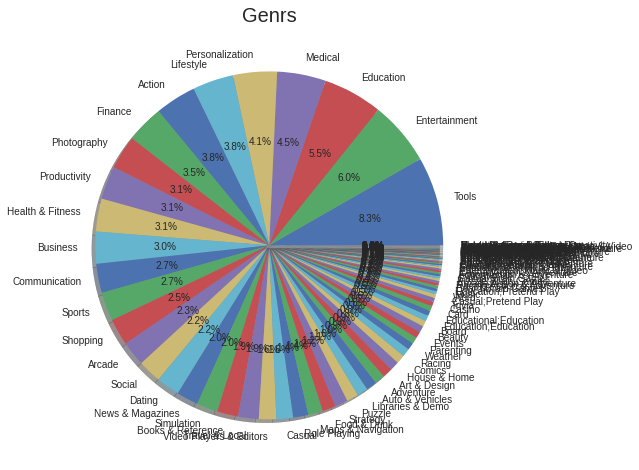

In [443]:
# Genrs 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(genres_count,labels=genres_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Genrs',size = 20)
plt.show()

In [444]:
train.groupby(['Category', 'Genres']).describe()

Rating            \
                                                           count      mean   
Category            Genres                                                   
ART_AND_DESIGN      Art & Design                            51.0  4.372549   
                    Art & Design;Creativity                  5.0  4.440000   
                    Art & Design;Pretend Play                1.0  3.900000   
AUTO_AND_VEHICLES   Auto & Vehicles                         55.0  4.252727   
BEAUTY              Beauty                                  34.0  4.300000   
BOOKS_AND_REFERENCE Books & Reference                      109.0  4.360550   
BUSINESS            Business                               166.0  4.155422   
COMICS              Comics                                  45.0  4.171111   
                    Comics;Creativity                        1.0  4.800000   
COMMUNICATION       Communication                          151.0  4.083444   
DATING              Dating                                 121.0  3.962810   
EDUCATION           Education                               74.0  4.351351   
                    Education;Action & Adventure             1.0  4.400000   
                    Education;Brain Games                    1.0  4.400000   
                    Education;Creativity                     2.0  4.450000   
                    Education;Education                      6.0  4.450000   
                    Education;Pretend Play                   4.0  4.625000   
ENTERTAINMENT       Entertainment                           58.0  4.158621   
                    Entertainment;Brain Games                2.0  4.500000   
                    Entertainment;Music & Video              4.0  3.925000   
EVENTS              Events                                  34.0  4.444118   
FAMILY              Action;Action & Adventure                8.0  4.300000   
                    Adventure;Action & Adventure             4.0  4.250000   
                    Adventure;Brain Games                    1.0  4.600000   
                    Adventure;Education                      1.0  4.100000   
                    Arcade;Action & Adventure               12.0  4.325000   
                    Arcade;Pretend Play                      1.0  4.500000   
                    Board;Action & Adventure                 3.0  4.033333   
                    Board;Brain Games                       13.0  4.353846   
                    Board;Pretend Play                       1.0  4.800000   
                    Books & Reference;Education              1.0  3.700000   
                    Card;Action & Adventure                  2.0  4.300000   
                    Casual                                  72.0  4.037500   
                    Casual;Action & Adventure               10.0  4.140000   
                    Casual;Brain Games                      10.0  4.540000   
                    Casual;Creativity                        5.0  4.400000   
                    Casual;Education                         3.0  4.266667   
                    Casual;Music & Video                     1.0  4.100000   
                    Casual;Pretend Play                     19.0  4.210526   
                    Education                              235.0  4.338723   
                    Education;Action & Adventure             2.0  4.250000   
                    Education;Creativity                     2.0  4.300000   
                    Education;Education                     24.0  4.325000   
                    Education;Music & Video                  2.0  4.100000   
                    Education;Pretend Play                  11.0  4.290909   
                    Educational                             10.0  4.170000   
                    Educational;Action & Adventure           2.0  4.150000   
                    Educational;Brain Games                  5.0  4.160000   
                    Educational;Creativity                   3.0  3.866667   
  

`Category` 변수와 `Genres` 변수와 그에 해당하는 앱들을 살펴 보았을 때 서로 동일한 경우가 많은 것을 확인할 수 있었다. 서로 다른 경우, `Genres`가 `Cateory`보다 조금 더 자세하게, 여러 값을 가지는 경우가 많았다. `Genres` 변수의 경우, 세분화된 값(여러 값, 동의어 등)을 가지는 앱들이 1개인 경우가 많았기에 `Category`변수 하나만을 고려하는 것이 더 적합하다고 생각되어 제거하기로 결정하였다. 

In [445]:
# Genre 변수 제거
train = train.drop(['Genres'], axis=1)
test = test.drop(['Genres'], axis=1)

In [446]:
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,2018-01-07
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,2018-01-15
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,2018-08-01
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,2018-06-08
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,2018-06-20


In [447]:
test.head()

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,Dr.Android Repair Master 2017,PRODUCTIVITY,1205,4.3,100000.0,0,0.00,Everyone,2018-06-10
1,DR CONTROL,FAMILY,267,1.5,10000.0,0,0.00,Everyone,2017-03-08
2,Dr Driving Racer,GAME,183,68.0,10000.0,0,0.00,Everyone,2018-06-14
3,Dr. McDougall Mobile Cookbook,HEALTH_AND_FITNESS,76,1.2,1000.0,1,4.99,Everyone,2015-01-26
4,Dr. Seuss's ABC,FAMILY,429,12.0,10000.0,1,3.99,Everyone,2018-02-26


### 날짜 변수 변환

In [448]:
# Last Updated 는 마지막으로 업데이트한 날짜를 포함하는 column
# 마지막 업데이트부터의 날짜를 정수로 나타내기
import datetime
from datetime import date

today = date.today()

train['today'] = today #  오늘 날짜 저장하는 column
train['today'] = pd.to_datetime(train['today'])
train['Last Updated'] = pd.to_datetime(train['Last Updated'])
train['Days Updated'] = (train['today'] - train['Last Updated']).dt.days # 마지막 업데이트 날짜로부터 며칠 지났는지
train.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,today,Days Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,2018-01-07,2021-02-23,1143
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,2018-01-15,2021-02-23,1135
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,2018-08-01,2021-02-23,937
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,2018-06-08,2021-02-23,991
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,2018-06-20,2021-02-23,979


In [449]:
# 비슷한 변수가 많을 시 computational cost가 올라가므로 Last Updated column 삭제하기
# 임시로 만든 today column 도 삭제

del train['Last Updated']
del train['today']
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Days Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,1143
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,1135
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,937
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,991
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,979


In [450]:
## test dataset에서도 'Days Updated' 변수 생성, 'Last Update'변수 삭제하기

test['today'] = today #  오늘 날짜 저장하는 column
test['today'] = pd.to_datetime(test['today'])
test['Last Updated'] = pd.to_datetime(test['Last Updated'])
test['Days Updated'] = (test['today'] - test['Last Updated']).dt.days # 마지막 업데이트 날짜로부터 며칠 지났는지
test.head()

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,today,Days Updated
0,Dr.Android Repair Master 2017,PRODUCTIVITY,1205,4.3,100000.0,0,0.00,Everyone,2018-06-10,2021-02-23,989
1,DR CONTROL,FAMILY,267,1.5,10000.0,0,0.00,Everyone,2017-03-08,2021-02-23,1448
2,Dr Driving Racer,GAME,183,68.0,10000.0,0,0.00,Everyone,2018-06-14,2021-02-23,985
3,Dr. McDougall Mobile Cookbook,HEALTH_AND_FITNESS,76,1.2,1000.0,1,4.99,Everyone,2015-01-26,2021-02-23,2220
4,Dr. Seuss's ABC,FAMILY,429,12.0,10000.0,1,3.99,Everyone,2018-02-26,2021-02-23,1093


In [451]:
# 비슷한 변수가 많을 시 computational cost가 올라가므로 Last Updated column 삭제하기
# 임시로 만든 today column 도 삭제

del test['Last Updated']
del test['today']
test.head()

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Days Updated
0,Dr.Android Repair Master 2017,PRODUCTIVITY,1205,4.3,100000.0,0,0.00,Everyone,989
1,DR CONTROL,FAMILY,267,1.5,10000.0,0,0.00,Everyone,1448
2,Dr Driving Racer,GAME,183,68.0,10000.0,0,0.00,Everyone,985
3,Dr. McDougall Mobile Cookbook,HEALTH_AND_FITNESS,76,1.2,1000.0,1,4.99,Everyone,2220
4,Dr. Seuss's ABC,FAMILY,429,12.0,10000.0,1,3.99,Everyone,1093


In [452]:
train.info() # Days Updated 연속형 변수

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5590 non-null   object 
 1   Category        5590 non-null   object 
 2   Rating          5590 non-null   float64
 3   Reviews         5590 non-null   int64  
 4   Size            5590 non-null   float64
 5   Installs        5590 non-null   float64
 6   Type            5590 non-null   int64  
 7   Price           5590 non-null   float64
 8   Content Rating  5590 non-null   object 
 9   Days Updated    5590 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 436.8+ KB


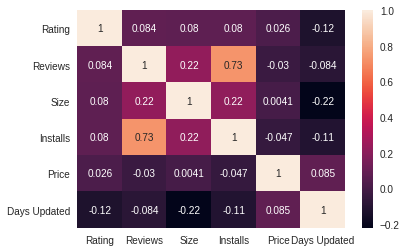

In [453]:
# 연속형 변수들 간의 상관관계 다시 확인하기
sns.heatmap(train.drop(['Type'], axis=1).corr(), annot=True) 

# `Rating` 변수와의 상관관계를 보았을 때, 업데이트가 최근에 되었을수록(Days Updated 값이 작을수록) 평점이 높다는 것을 확인할 수 있다

## 2. Regression Modeling  


In [536]:
# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [455]:
print("train:",train.columns)
print("test:", test.columns)

train: Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Days Updated'],
      dtype='object')
test: Index(['App', 'Category', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Days Updated'],
      dtype='object')


In [456]:
# Categorical Numerical 변수

# App column은 인덱스와 같이 각 앱마다 고유의 이름 값을 가지고 있으므로 제외
cat = ['Category', 'Type','Content Rating']
num = ['Reviews','Size', 'Installs', 'Price', 'Days Updated'] # Rating은 target 변수 (포함X)

In [457]:
rating = pd.DataFrame(train['Rating'])

In [458]:
train_cat = pd.DataFrame(train[cat])
train_num = pd.DataFrame(train[num])
test_cat = pd.DataFrame(test[cat])
test_num = pd.DataFrame(test[num])

In [459]:
train.shape

(5590, 10)

### One-Hot-Encoding

`Category`, `Type`, `Content Rating` 변수 one-hot-encoding


In [460]:
train['Category'].value_counts()

FAMILY                 1098
GAME                    652
TOOLS                   462
MEDICAL                 253
PERSONALIZATION         227
LIFESTYLE               215
FINANCE                 195
PHOTOGRAPHY             175
PRODUCTIVITY            172
HEALTH_AND_FITNESS      171
BUSINESS                166
COMMUNICATION           151
SPORTS                  143
SHOPPING                139
SOCIAL                  122
DATING                  121
NEWS_AND_MAGAZINES      113
BOOKS_AND_REFERENCE     109
TRAVEL_AND_LOCAL        108
VIDEO_PLAYERS            90
EDUCATION                88
MAPS_AND_NAVIGATION      76
FOOD_AND_DRINK           69
ENTERTAINMENT            64
ART_AND_DESIGN           57
LIBRARIES_AND_DEMO       57
AUTO_AND_VEHICLES        55
HOUSE_AND_HOME           48
COMICS                   46
PARENTING                43
WEATHER                  37
EVENTS                   34
BEAUTY                   34
Name: Category, dtype: int64

In [461]:
# Category 변수 dummy
category_train = pd.DataFrame(pd.get_dummies(train['Category'], prefix='cat'))
category_test = pd.DataFrame(pd.get_dummies(test['Category'], prefix='cat'))

In [462]:
print(category_train.shape)
category_train.head()

(5590, 33)


,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EDUCATION,cat_ENTERTAINMENT,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [463]:
print(category_test.shape)
category_test.head()

(1404, 31)


,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [464]:
# dummy 변수화한 Category를 살펴보면 test에 존재하지 않는 category가 2개 있다
np.setdiff1d(list(category_train.columns), list(category_test.columns))


array(['cat_EDUCATION', 'cat_ENTERTAINMENT'], dtype='<U23')

In [465]:
# category_test에 'cat_EDUCATION', 'cat_ENTERTAINMENT' 변수 추가
category_test['cat_EDUCATION'] = 0
category_test['cat_ENTERTAINMENT'] = 0
category_test.shape # category_train과 동일한 변수들을 가지게 되었다

(1404, 33)

In [466]:
## Content Ratin 변수 dummy
contrat_train = pd.DataFrame(pd.get_dummies(train['Content Rating'], prefix='contrat'))
contrat_test = pd.DataFrame(pd.get_dummies(test['Content Rating'], prefix='contrat'))

In [467]:
print(contrat_train.shape)
contrat_train.head()

(5590, 6)


,contrat_Adults only 18+,contrat_Everyone,contrat_Everyone 10+,contrat_Mature 17+,contrat_Teen,contrat_Unrated
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,0,1,0,0,0,0


In [468]:
print(contrat_test.shape)
contrat_test.head()

(1404, 4)


,contrat_Everyone,contrat_Everyone 10+,contrat_Mature 17+,contrat_Teen
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [469]:
# 'contrat_Adults only 18+', 'contrat_Unraated'변수 test 데이터에 추가
contrat_test['contrat_Adults only 18+'] = 0
contrat_test['contrat_Unrated'] = 0
contrat_test.head()

,contrat_Everyone,contrat_Everyone 10+,contrat_Mature 17+,contrat_Teen,contrat_Adults only 18+,contrat_Unrated
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [470]:
# Type 변수 one-hot-encoding
type_train = pd.DataFrame(pd.get_dummies(train['Type'],  prefix='pay'))
type_test = pd.DataFrame(pd.get_dummies(test['Type'], prefix='pay'))

In [471]:
print(type_train.shape)
type_train.head()

(5590, 2)


,pay_0,pay_1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [472]:
print(type_test.shape)
type_test.head()

(1404, 2)


,pay_0,pay_1
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1


### Numerical Variable Scaling

In [473]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_scaled = scaler.fit_transform(train_num)
train_scaled = pd.DataFrame(train_scaled, columns = train_num.columns)
test_scaled = scaler.fit_transform(test_num)
test_scaled = pd.DataFrame(test_scaled, columns = test_num.columns)

In [474]:
## 데이터셋 합치기

train2 = pd.concat([train_scaled, type_train, contrat_train, rating], axis=1)
train2.head()


,Reviews,Size,Installs,Price,Days Updated,pay_0,pay_1,contrat_Adults only 18+,contrat_Everyone,contrat_Everyone 10+,contrat_Mature 17+,contrat_Teen,contrat_Unrated,Rating
0,-0.061106,0.240964,-0.090909,0.0,0.376368,1,0,0,1,0,0,0,0,4.1
1,-0.036413,0.040161,0.404040,0.0,0.353027,1,0,0,1,0,0,0,0,3.9
2,2.608383,-0.172691,4.949495,0.0,-0.224654,1,0,0,1,0,0,0,0,4.7
3,6.524219,0.481928,50.404040,0.0,-0.067104,1,0,0,0,0,0,1,0,4.5
4,-0.036413,-0.409639,0.000000,0.0,-0.102115,1,0,0,1,0,0,0,0,4.3


In [475]:
# pd.set_option('display.max_rows', None)
# train2

In [476]:
test2 = pd.concat([test_scaled, type_test, contrat_test], axis=1)
test2.head()

,Reviews,Size,Installs,Price,Days Updated,pay_0,pay_1,contrat_Everyone,contrat_Everyone 10+,contrat_Mature 17+,contrat_Teen,contrat_Adults only 18+,contrat_Unrated
0,0.113253,-0.265517,0.100200,0.00,-0.253602,1,0,1,0,0,0,0,0
1,-0.016140,-0.362069,-0.080160,0.00,0.628242,1,0,1,0,0,0,0,0
2,-0.027727,1.931034,-0.080160,0.00,-0.261287,1,0,1,0,0,0,0,0
3,-0.042487,-0.372414,-0.098196,4.99,2.111431,0,1,1,0,0,0,0,0
4,0.006208,0.000000,-0.080160,3.99,-0.053794,0,1,1,0,0,0,0,0


### Modeling

In [477]:
## target 분리, data split
X = train2.drop(['Rating'], axis=1)
y = train2['Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=318)

In [478]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Reviews                  1404 non-null   float64
 1   Size                     1404 non-null   float64
 2   Installs                 1404 non-null   float64
 3   Price                    1404 non-null   float64
 4   Days Updated             1404 non-null   float64
 5   pay_0                    1404 non-null   uint8  
 6   pay_1                    1404 non-null   uint8  
 7   contrat_Everyone         1404 non-null   uint8  
 8   contrat_Everyone 10+     1404 non-null   uint8  
 9   contrat_Mature 17+       1404 non-null   uint8  
 10  contrat_Teen             1404 non-null   uint8  
 11  contrat_Adults only 18+  1404 non-null   int64  
 12  contrat_Unrated          1404 non-null   int64  
dtypes: float64(5), int64(2), uint8(6)
memory usage: 85.1 KB


In [479]:
# Update test data
# test_ID = test['Id']
# test = test[['Reviews','Size','Installs','Price']]

* validation function

In [480]:
n_folds = 5
def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
  rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
  return (rmse)

In [481]:
def rmse(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

### Base models  
scaler 로  RobustScaler를 사용 (이상치의 영향을 줄여준다고 함)

* Linear Regression
* LASSO 나 Lidge를 써보셔도 좋습니다
* pipeline은 전처리 후 모델로 넘어가는 과정을 구현할 때 자주 사용합니다.
* 전처리를 따로 하고 모델에 데이터를 적용시키는 방법과 같지만, 더 짧은 코드로 번거롭지 않게 구현할 수 있다는 것이 장점입니다.
* train에 수행했던 전처리를 test에 동일하게 수행할 때도 같은 파이프라인에 대입하는 데이터만 달라지면 되기 때문에 코드가 간결해지는 장점이 있습니다.

In [482]:
lr = LinearRegression()

* DecisionTreeRegressor  
의사결정나무 dt입니다~ 약분류기를 만들어 주려고 깊이를 10만 설정해볼게요

In [483]:
dt = DecisionTreeRegressor(max_depth=10)

* KNN


In [484]:
knn = KNeighborsRegressor(n_neighbors = 3)

* SVM (Support Vector Machine)  


In [485]:
svm = SVR()

* Random Forest  
ensemble 모델 중에 bagging 모델의 한 종류라고 배운 random forest 입니다

In [486]:
rf = RandomForestRegressor()

* GBM  
Boosting 모델로 배운 Gradient boosting 입니다!

In [534]:
gbm = make_pipeline(GradientBoostingRegressor(n_estimators = 3000, learning_rate=0.05,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004))

* XGBoost

In [488]:
xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM

In [489]:
lgb = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20) 

### Base model Scores  
먼저 각 모델의 score를 봅시다.

In [490]:
score = rmse_cv(lr)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5470 (0.0301)



In [491]:
score = rmse_cv(dt)
print("\nDecision tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Decision tree score: 0.6110 (0.0265)



In [492]:
score = rmse_cv(knn)     
print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KNN score: 0.6122 (0.0307)



In [493]:
score = rmse_cv(svm)     
print("\nSVM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVM score: 0.5504 (0.0327)



In [494]:
score = rmse_cv(rf)     
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.5447 (0.0272)



In [495]:
score = rmse_cv(gbm)     
print("\nGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBM score: 0.5413 (0.0279)



In [496]:
score = rmse_cv(xgb)     
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


XGBoost score: 0.5481 (0.0262)



In [497]:
score = rmse_cv(lgb)     
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 0.5283 (0.0302)



KNN < Decision Tree < SVM > XGBoost > Linear Regression > Random Forest > Gradient Boost > LightGBM


(rmse score 낮을수록 좋음)

부스팅 계열은 시간이 정말 오래걸리죠  
아마 앙상블하고 튜닝하고 과제에 시간이 오래 걸릴겁니다!  
최선을 다해주세요~~

### 베이스 모델 튜닝
* Grid search, optuna , random Search 등을 이용해서 파라미터를 튜닝해주세요~!

In [517]:
# 베이스모델 튜닝을 진행해주세요
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [526]:
## LGBM Hyperparameter Tuning

lgb2 = lgb.LGBMRegressor(objective='regression')
param_grid_lgb = {'max_depth': [1, 3, 5, 7],
                 'n_estimators': [100, 200, 300],
                 'learning_rate': [0.01, 0.05, 0.1]}

grid_lgb = GridSearchCV(lgb2, param_grid = param_grid_lgb, cv=5, scoring='neg_mean_squared_error')
grid_lgb.fit(X_train.values, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 200, 300]},


In [531]:
print("Best Parameters: {}".format(grid_lgb.best_params_))
print("Best CV Score: {:.4f}".format(grid_lgb.best_score_))
print("Test Score: {:.4f}".format(grid_lgb.score(X_test, y_test)))

rmse(y_test,grid_lgb.predict(X_test))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV Score: -0.2717
Test Score: -0.2348


0.48451988951162334

In [532]:
lgb_update = lgb.LGBMRegressor(objective='regression',
                               learning_rate = 0.1,
                               max_depth = 3,
                               n_estimators = 100)

score = rmse_cv(lgb_update)     
print("\nUpdated LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
## 이전에 0.5283 -> 0.5204 로 성능이 좋아진 것을 확인할 수 있다!


Updated LGBM score: 0.5204 (0.0296)



In [540]:
## Gradient Boost Parameter Tuning

gbm2 = GradientBoostingRegressor()
param_grid_gbm = {'n_estimators' : [100, 200, 300],
                  'max_depth': [1, 3, 5, 7],
                  'learning_rate' : [0.01, 0.05, 0.1]}

grid_gbm = GridSearchCV(gbm2, param_grid= param_grid_gbm, cv=5, scoring='neg_mean_squared_error')
grid_gbm.fit(X_train.values, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...=None,
                      

In [541]:
print("Best Parameters: {}".format(grid_gbm.best_params_))
print("Best CV Score: {:.4f}".format(grid_gbm.best_score_))
print("Test Score: {:.4f}".format(grid_gbm.score(X_test, y_test)))

rmse(y_test,grid_gbm.predict(X_test))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best CV Score: -0.2756
Test Score: -0.2372


0.48705968760089435

In [543]:
gbm_update = GradientBoostingRegressor(max_depth = 3,
                                       learning_rate = 0.05,
                                       n_estimators = 200)

score = rmse_cv(gbm_update)     
print("\nUpdated GBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# 0.5413 -> 0.5242 로 성능이 좋아진 것을 확인


Updated GBM score: 0.5242 (0.0312)



In [560]:
## Random Forest

rf2 = RandomForestRegressor()
param_grid_rf = {'n_estimators' : [100, 200, 300],
                  'max_depth': [1, 3, 5, 7]}

grid_rf = GridSearchCV(rf2, param_grid= param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train.values, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [561]:
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Best CV Score: {:.4f}".format(grid_rf.best_score_))
print("Test Score: {:.4f}".format(grid_rf.score(X_test, y_test)))

rmse(y_test,grid_rf.predict(X_test))

Best Parameters: {'max_depth': 7, 'n_estimators': 300}
Best CV Score: -0.2772
Test Score: -0.2333


0.4829734160228443

In [562]:
rf_update = RandomForestRegressor(max_depth = 7,
                                  n_estimators = 300)

score = rmse_cv(rf_update)     
print("\nUpdated Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# 0.5447 -> 0.5261 로 성능이 좋아진 것을 확인


Updated Random Forest score: 0.5261 (0.0299)



In [570]:
import xgboost as xgb

xgb2 = xgb.XGBRegressor(colsample_bytree=0.4603,max_depth=3, min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

param_grid_xgb = {
    'learning_rate' : [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(xgb2, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_xgb.fit(X_train.values, y_train)

print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

-0.28042082190456413
{'learning_rate': 0.01}


In [571]:
xgb_update = xgb.XGBRegressor(colsample_bytree=0.4603,max_depth=3, min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1, learning_rate = 0.01)

score = rmse_cv(xgb_update)     
print("\nUpdated XGBost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# 0.5481-> 0.5287 로 성능이 좋아진 것을 확인


Updated XGBost score: 0.5287 (0.0295)



# 3. Stacking models   
basic & cv 기반

* Averaged base models class

In [563]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X_test):
        predictions = np.column_stack([
            model.predict(X_test) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

* Averaged base models score  
앞서 업데이트한 모델 (lightgbm, gradient boost, random forest) 사용

In [564]:
averaged_models = AveragingModels(models = (lgb_update, gbm_update, rf_update))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.4850 (0.0263)



### Less simple Stacking : Adding a Meta-model  
단순 평균 합산이 아닌 meta model 을 학습시켜주는 stacking 방법입니다!  
다른 방법을 쓰시거나 직접 구현하셔도 되고 아래의 코드를 쓰셔도 됩니다  
사이킷런 라이브러리로는 vecstack 이 있고, keras 를 이용한 방법도 구글링하면 많이 나옵니다!

* KFold 기반 Stacking

In [566]:
def get_stacking_data(model, X_train, y_train, X_test, n_folds=10):
  kfold = KFold(n_splits = n_folds, random_state = 1004)
  
  # 최종 모델에서 사용할 데이터 셋 세팅 (0 값으로)
  # 만약 shape가 (100,10)이었으면 폴드의 검증 과정 중 저장할 데이터는 (100,1)으로 한다.
  train_fold_predict = np.zeros((X_train.shape[0],1))
  # test 는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold갯수) 모양이다.
  # 해당 폴드마다 X_test의 예측 값을 fold 에 넣는다! meta model 이 쓸꺼임
  test_predict = np.zeros((X_test.shape[0], n_folds))
  print('model : ',model.__class__.__name__)
  
  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_valid = X_train.iloc[valid_index]

    # 학습
    model.fit(X_train_,y_train_)
    # 해당 폴드에서 학습된 모델에다가 검증 데이터 (X_valid)로 예측 후 저장
    train_fold_predict[valid_index,:] = model.predict(X_valid).reshape(-1,1)
    # 해당 폴드에서 생성된 모델에게 원본 테스트 데이터 (X_test)를 이용해서 예측하고 저장
    test_predict[:,cnt] = model.predict(X_test)
  
  # for 문이 끝나면 test_pred는 평균을 내서 하나로 합친다.
  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  
  return train_fold_predict, test_predict_mean

In [567]:
# 앙상블 수행 lgb_update, gbm_update, rf_update
lgb_train, lgb_test = get_stacking_data(lgb_update, X_train, y_train, X_test)
gbm_train, gbm_test = get_stacking_data(gbm_update, X_train, y_train, X_test)
rf_train, rf_test = get_stacking_data(rf_update, X_train, y_train, X_test)

model :  LGBMRegressor
model :  GradientBoostingRegressor
model :  RandomForestRegressor


In [568]:
# return 된 kfold 결과와 X_test 결과를 skacking
new_X_train = np.concatenate((lgb_train,gbm_train,rf_train), axis=1)
new_X_test = np.concatenate((lgb_test,gbm_test,rf_test), axis=1)

print('원본 : ', X_train.shape, X_test.shape)
print('새로운 : ', new_X_train.shape, new_X_test.shape)

원본 :  (3912, 13) (1678, 13)
새로운 :  (3912, 3) (1678, 3)


In [589]:
# 최종 모델 훈련
xgb_update.fit(new_X_train,y_train)
stack_pred = xgb_update.predict(new_X_test)

print("\n Final score: {:.4f}".format(rmse(y_test,stack_pred)))


 Final score: 0.4973


성능이 별로 좋지 않습니다. 여러분이 개선해주세요~!  
StratifiedKFold도 사용해보세요!  https://lsjsj92.tistory.com/559

* StackingAveragedModels  
meta model을 사용하는 StackingAveragedModels class를 사용하겠습니당

In [590]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model 
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [610]:
stacked_averaged_models = StackingAveragedModels(base_models = [lgb_update,gbm_update,rf_update],
                                                 meta_model = xgb_update)

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = stacked_averaged_models.predict(test2)


In [611]:
print(rmse(y, stacked_train_pred))

0.49248968711698343


* sklearn.ensemble.StackingRegressor  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

In [615]:
from sklearn.ensemble import StackingRegressor

In [617]:
# 파라미터 설정
estimators = [
              ('lgb', lgb_update),
              ('gbm',gbm_update),
              ('rf',rf_update)
]
              
# Stacking
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = xgb_update,
    cv = 10,
    n_jobs=3,
    verbose=3
    )

# fit
reg.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('lgb',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=3,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31,
                                             objective='regression',
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silen...
                                       

In [618]:
# rmse
rmse(y_test,reg.predict(X_test))

0.49393739965301725

### Final Training and Prediction  


* Ensemble prediction

In [621]:
ensemble = reg.predict(test2)

* Submission

In [622]:
sub = pd.DataFrame()
sub['Id'] = list(range(5617, 7021))
sub['Rating'] = ensemble
sub.to_csv('submission_taehee.csv',index=False)

In [614]:
sub.head()

,Id,Rating
0,5617,4.322063
1,5618,4.318489
2,5619,4.118413
3,5620,4.375238
4,5621,4.520763


### submission.csv 파일을 제출하시면 됩니다!  
제출은 하루에 10번 까지 가능합니다~!
